In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import random
import json
import os
import pandas as pd
import matplotlib.dates as mdates

In [7]:
# %cd ..

In [8]:
config_path = 'data/TUDelft/output_20240911_205946/config.json'
ground_truth_path = 'data/TUDelft/measured_data.csv'


In [9]:
with open(config_path, 'r') as file:
    CONFIG = json.load(file)
    print(CONFIG)

{'area_per_point': 9, 'azimuth_resolution': 5, 'elevation_resolution': 5, 'epw_file': 'rotterdam.epw', 'global_irradiance_time': 1834.2714636325836, 'irradiance_batch_size': 500, 'irradiance_model': 'isotropic', 'num_bounces': 2, 'output_folder_name': 'output_20240911_205946', 'result': {'bbox_max': [85675.1015625, 446983.46875, 95.04199981689453], 'bbox_min': [84501.5625, 445805.0, -3.7470016479492188], 'global_irradiance_time': 8017.015613794327, 'num_timesteps': 45, 'shadow_calculation_time': 0.24601151049137115, 'viewshed_rendering_time': 26.755939483642578, 'voxel_dim_x': 131, 'voxel_dim_y': 131, 'voxel_dim_z': 11}, 'scenario': 'tud', 'study_area': {'data_root': './data/TUDelft', 'end_time': '2021-02-02 00:00:00', 'frequency': '10min', 'lat': 52.00091589108101, 'long': 4.372930257905266, 'start_time': '2021-02-01 00:00:00', 'timezone': 'Europe/Amsterdam'}, 'voxel_resolution': 9}


In [10]:
folder_path = CONFIG['study_area']['data_root']
data_root = os.path.join(folder_path, CONFIG['output_folder_name'])
point_grid_path = os.path.join(data_root, 'intermediate', 'point_grid.dat')
index_map_path = os.path.join(data_root,  'index_map.dat')
shadow_map_path = os.path.join(data_root, 'shadow_map.dat')
sun_pos_path = os.path.join(data_root, 'intermediate', 'sun_pos.csv')


horizon_factor_path = os.path.join(data_root, 'horizon_factor_map.dat')
sky_view_factor_path = os.path.join(data_root,  'sky_view_factor_map.dat')
cosine_map_path = os.path.join(data_root, 'cosine_map.dat')

voxel_size = CONFIG['voxel_resolution']
num_azimuth = 360//CONFIG['azimuth_resolution']
num_elevation = 90//CONFIG['elevation_resolution']
print(num_azimuth, num_elevation)
num_samples = num_azimuth*num_elevation
index_dim = (num_elevation,num_azimuth)

estimated_irradiance_path = os.path.join(data_root, 'irradiance.npy')
simplified_irradiance_path = os.path.join(data_root, 'simplified_irradiance.npy')
weather_data_path = os.path.join(data_root, 'weather_data.npy')

point_grid = np.loadtxt(point_grid_path)
estimated_irradiance = np.load(estimated_irradiance_path)
simplified_irradiance = np.load(simplified_irradiance_path)
# weather_data = np.load(weather_data_path)

72 18


In [18]:
total_areas_path = os.path.join(data_root, 'triangle_areas.dat')
total_areas = np.fromfile(total_areas_path,dtype=np.float64)
filtered_areas = total_areas[total_areas <= 100]
from matplotlib.ticker import FormatStrFormatter, MaxNLocator


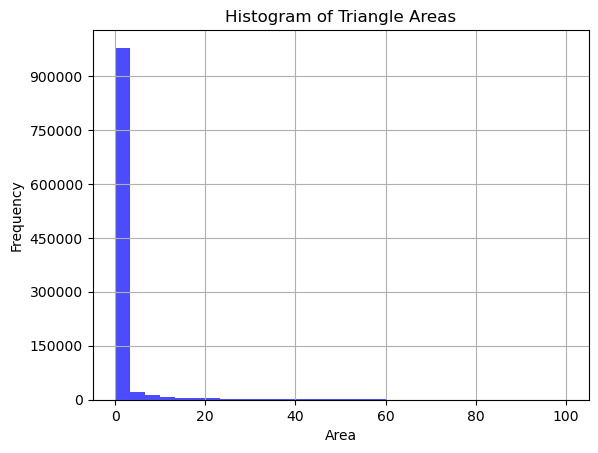

In [19]:
plt.hist(filtered_areas, bins=30, color='blue', alpha=0.7)  # bins参数控制直方图的柱子数量
plt.title('Histogram of Triangle Areas')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d'))

# 或者使用MaxNLocator来避免科学计数法
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)
plt.savefig(f"./data/figures/Delft_areas.png", bbox_inches='tight', pad_inches=0, dpi=300)
plt.show()

In [94]:
def print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, point_idx):
    horizon_factor_path = np.memmap(horizon_factor_path, dtype=np.float16, mode='r')
    sky_view_factor_path = np.memmap(sky_view_factor_path, dtype=np.int32, mode='r')
    index_map = np.memmap(index_map_path, dtype=np.uint32, mode='r')
    # cosine_map = np.memmap(cosine_map_path, dtype=np.float16, mode='r')

    num_samples = index_dim[0]*index_dim[1]
    index_start = point_idx*num_samples
    index_end = (point_idx+1)*num_samples

    voxel_indices = index_map[index_start:index_end]
    # breakpoint()
    voxel_indices = voxel_indices.reshape(index_dim)
    unique_values = np.unique(voxel_indices)

    # sum_of_cosine = np.sum(cosine_map[index_start*6:index_end*6])
    # print("sum of cosine: ", sum_of_cosine)

    # 创建一个随机颜色映射，确保白色为最大值对应的颜色
    colors = {}
    for value in unique_values:
        # print(value)
        if value == 4294967295:
            colors[value] = (1.0, 1.0, 1.0)  # 白色
        else:
            colors[value] = (random.random(), random.random(), random.random())

    # 将图像数据转换为 RGB
    image = np.zeros((voxel_indices.shape[0], voxel_indices.shape[1], 3))

    for i in range(voxel_indices.shape[0]):
        for j in range(voxel_indices.shape[1]):
            image[i, j] = colors[voxel_indices[i, j]]

    # image = np.flipud(image)
    plt.xticks(np.linspace(0, voxel_indices.shape[1] - 1, num=5), 
           labels=np.linspace(0, 360, num=5).astype(int))  # 横轴 azimuth 从 0 到 360 度

    plt.yticks(np.linspace(0, voxel_indices.shape[0] - 1, num=4), 
            labels=np.linspace(90, 0, num=4).astype(int))  # 纵轴 elevation 从 0 到 90 度

    # 添加坐标轴标签
    plt.xlabel('Azimuth (degrees)')
    plt.ylabel('Elevation (degrees)')

    plt.imshow(image)
    # plt.savefig('S3.png', bbox_inches='tight', pad_inches=0, dpi=300)
    # plt.axis('off')  # 隐藏坐标轴
    plt.show()

    print("sky view factor: ", sky_view_factor_path[point_idx]/num_samples)
    print("horizon factor: ", horizon_factor_path[point_idx])
    formatted_values = [f"{x:.5f}" for x in point_grid[point_idx]]
    print("point info: ", formatted_values)

    



In [95]:
def obtain_tud(ground_recording_filename, sunpos_filename):
    sunpos = pd.read_csv(sunpos_filename)
    sunpos.columns.values[0]='timestamp'
    ground_recording = pd.read_csv(ground_recording_filename)
    sunpos['timestamp'] = pd.to_datetime(sunpos['timestamp']).dt.tz_localize(None)
    ground_recording['local_time'] = pd.to_datetime(ground_recording['local_time'])
    filtered_ground_recording = ground_recording[ground_recording['local_time'].isin(sunpos['timestamp'])]
    filtered_ground_recording = filtered_ground_recording.drop_duplicates(subset='local_time', keep='first').reset_index(drop=True)


    ground_measurement = filtered_ground_recording.copy()
    ground_measurement['zenith_angle'] = 90 - ground_measurement['sun_altitude']

    # 将天顶角从度数转换为弧度
    ground_measurement['theta_radians'] = np.radians(ground_measurement['zenith_angle'])

    # 计算 GHI
    ground_measurement['GHI'] = ground_measurement['DHI'] + ground_measurement['DNI'] * np.cos(ground_measurement['theta_radians'])

    # 如果不需要 'theta_radians' 和 'zenith_angle' 列，可以将其删除
    ground_measurement.drop(columns=['theta_radians', 'zenith_angle'], inplace=True)

    
    return ground_measurement

In [96]:
def calculate_metrics(y_true, y_pred):
    # 计算均值
    mean_y_true = np.mean(y_true)
    
    # Pearson Correlation Coefficient
    correlation = np.corrcoef(y_true, y_pred)[0, 1]
    
    # nMBE (normalized Mean Bias Error)
    mbe = np.mean(y_pred - y_true)
    nMBE = mbe / mean_y_true
    
    # nMAE (normalized Mean Absolute Error)
    mae = np.mean(np.abs(y_pred - y_true))
    nMAE = mae / mean_y_true
    
    # nRMSE (normalized Root Mean Squared Error)
    rmse = np.sqrt(np.mean((y_pred - y_true) ** 2))
    nRMSE = rmse / mean_y_true
    
    return correlation, nMBE, nMAE, nRMSE

In [97]:
s1_idx = 1119236 # s1
s2_idx = 1130787 # s2
# print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, s1_idx)
# print_point_info(point_grid, horizon_factor_path, sky_view_factor_path, index_map_path, cosine_map_path, index_dim, s2_idx)

In [98]:
ground_measurement = obtain_tud(ground_truth_path, sun_pos_path)

In [99]:
ground_measurement

,local_time,time_zone,valid,DHI,DNI,sun_azimuth,sun_altitude,S1,S2,GHI
0,2021-02-01 09:00:00,1,1,9.553145,0,124.705717,4.166216,8.589,3,9.553145
1,2021-02-01 09:10:00,1,1,12.793280,0,126.753654,5.419022,11.910,5,12.793280
2,2021-02-01 09:20:00,1,1,20.197844,0,128.818962,6.634685,18.150,7,20.197844
3,2021-02-01 09:30:00,1,1,26.488326,0,130.916774,7.819323,24.020,10,26.488326
4,2021-02-01 09:40:00,1,1,38.159428,0,133.037872,8.964906,33.580,14,38.159428
5,2021-02-01 09:50:00,1,1,38.164537,0,135.186755,10.071378,37.470,15,38.164537
6,2021-02-01 10:00:00,1,1,42.381409,0,137.360617,11.134916,39.250,16,42.381409
7,2021-02-01 10:10:00,1,1,60.326577,0,139.571076,12.158645,53.220,22,60.326577
8,2021-02-01 10:20:00,1,1,47.732579,0,141.807618,13.135236,46.140,19,47.732579
9,2021-02-01 10:30:00,1,1,58.269139,0,144.070313,14.062818,57.590,23,58.269139


In [100]:
def plot_irradiance(ground_measurement, estimated_irradiance, simplified_irradiance, s1_idx, s2_idx):
    plt.figure(figsize=(12, 8))
    ground_measurement['local_time'] = pd.to_datetime(ground_measurement['local_time'])
    first_datetime_str = ground_measurement.loc[0, 'local_time']

# 转换为日期时间对象并提取日期部分
    first_date = pd.to_datetime(first_datetime_str).date()
    time_formatter = mdates.DateFormatter('%H:%M')

    for i in range(3):
        # plt.plot(estimated_irradiance[i][s1_idx], label=f"Bounce {i}", marker='o')
        plt.plot(ground_measurement['local_time'], estimated_irradiance[i][s1_idx], label=f"Bounce {i}", marker='o', markersize=2)
        correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S1'].values, estimated_irradiance[i][s1_idx])
        print(f"Bounce {i} correlation: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")

    # simplified_prediction = estimated_irradiance[0][s1_idx] + ground_measurement['GHI'].values * 0.2
    direct_simplified_diffuse_reflect = simplified_irradiance[0][s1_idx] + simplified_irradiance[1][s1_idx] + simplified_irradiance[2][s1_idx]
    direct_simplified_reflect = estimated_irradiance[0][s1_idx] + simplified_irradiance[2][s1_idx]

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S1'].values, direct_simplified_diffuse_reflect)
    print(f"simplified svf and no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_diffuse_reflect, label="simplified svf and no global reflective", marker='o', markersize=2)

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S1'].values, direct_simplified_reflect)
    print(f"no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_reflect, label="no global reflective", marker='o', markersize=2)

    plt.plot(ground_measurement['local_time'], ground_measurement['S1'].values, label="S1 ground measurements", marker='o',markersize=2, linewidth=4, color='#8B0000')
    

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Comparison of Estimated Irradiance and Weather Data")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(time_formatter)
    # plt.xticks(rotation=45)  # Rotate x-axis labels to make them readable
    # plt.tight_layout()
    plt.savefig(f"./data/figures/S1_{first_date}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()


    plt.figure(figsize=(12, 8))

    for i in range(3):
        plt.plot(ground_measurement['local_time'], estimated_irradiance[i][s2_idx], label=f"Bounce {i}", marker='o', markersize=2)
        correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S2'].values, estimated_irradiance[i][s2_idx])
        print(f"Bounce {i} correlation: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")

    # simplified_prediction = estimated_irradiance[0][s2_idx] + ground_measurement['GHI'].values * 0.2
    direct_simplified_diffuse_reflect = simplified_irradiance[0][s2_idx] + simplified_irradiance[1][s2_idx] + simplified_irradiance[2][s2_idx]
    direct_simplified_reflect = estimated_irradiance[0][s2_idx] + simplified_irradiance[2][s2_idx]

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S2'].values, direct_simplified_diffuse_reflect)
    print(f"simplified svf and no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_diffuse_reflect, label="simplified svf and no global reflective", marker='o', markersize=2)

    correlation, nMBE, nMAE, nRMSE = calculate_metrics(ground_measurement['S2'].values, direct_simplified_reflect)
    print(f"no global reflective: {correlation:.4f}, nMBE: {nMBE:.4f}, nMAE: {nMAE:.4f}, nRMSE: {nRMSE:.4f}")
    plt.plot(ground_measurement['local_time'], direct_simplified_reflect, label="no global reflective", marker='o', markersize=2)


    plt.plot(ground_measurement['local_time'], ground_measurement['S2'].values, label="S2 ground measurements", marker='o', markersize=2, linewidth=4, color='#8B0000')

    plt.xlabel("Timestep")
    plt.ylabel("Value")
    plt.title("Comparison of Estimated Irradiance and Weather Data")
    plt.legend()
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(time_formatter)
    plt.savefig(f"./data/figures/S2_{first_date}.png", bbox_inches='tight', pad_inches=0, dpi=300)
    plt.show()

Bounce 0 correlation: 0.9960, nMBE: -0.0110, nMAE: 0.0406, nRMSE: 0.0576
Bounce 1 correlation: 0.9960, nMBE: 0.0370, nMAE: 0.0553, nRMSE: 0.0811
Bounce 2 correlation: 0.9960, nMBE: 0.0477, nMAE: 0.0628, nRMSE: 0.0904
simplified svf and no global reflective: 0.9960, nMBE: 0.0821, nMAE: 0.0909, nRMSE: 0.1244
no global reflective: 0.9960, nMBE: 0.0019, nMAE: 0.0409, nRMSE: 0.0597


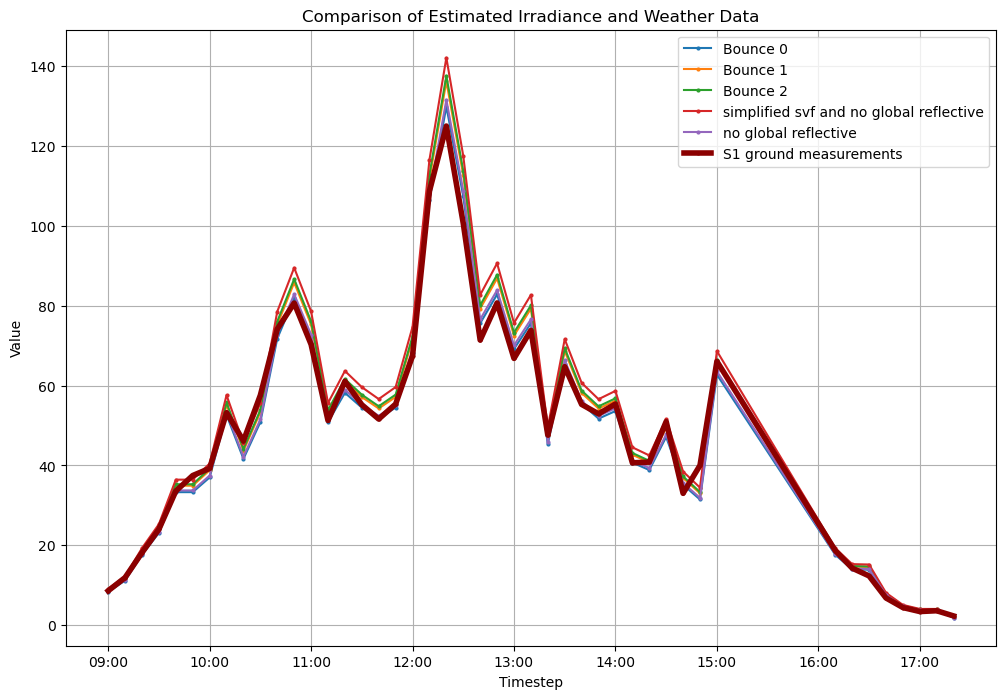

Bounce 0 correlation: 0.9966, nMBE: -0.1822, nMAE: 0.1835, nRMSE: 0.2150
Bounce 1 correlation: 0.9966, nMBE: 0.2880, nMAE: 0.2880, nRMSE: 0.3498
Bounce 2 correlation: 0.9966, nMBE: 0.5108, nMAE: 0.5108, nRMSE: 0.6109
simplified svf and no global reflective: 0.9966, nMBE: 0.6059, nMAE: 0.6059, nRMSE: 0.7227
no global reflective: 0.9966, nMBE: 0.0854, nMAE: 0.0874, nRMSE: 0.1190


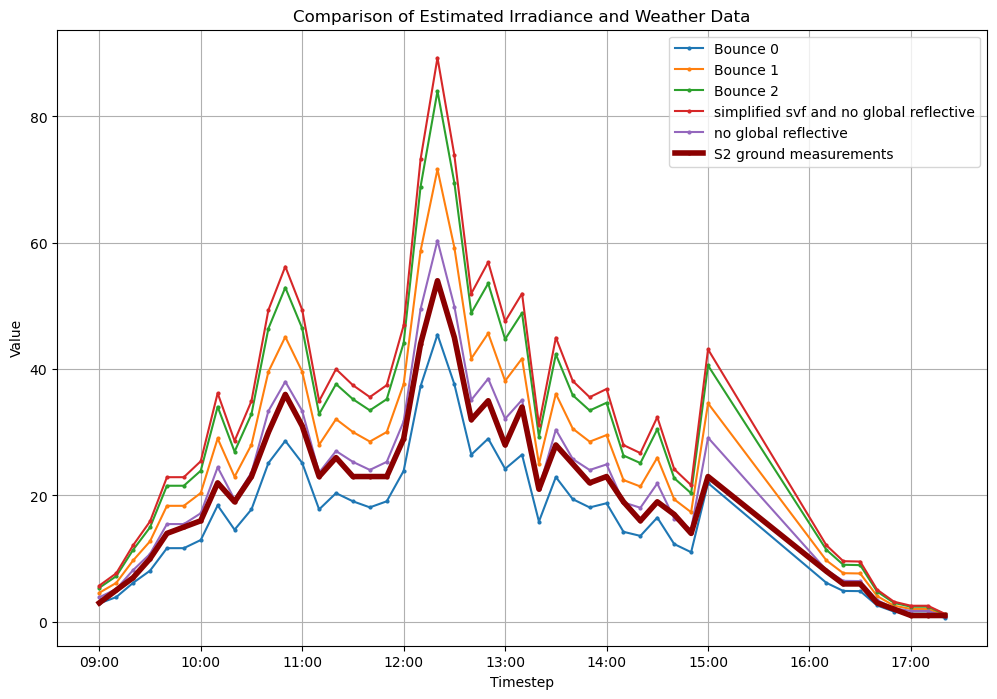

In [101]:
plot_irradiance(ground_measurement, estimated_irradiance, simplified_irradiance, s1_idx, s2_idx)

In [102]:
# plot_irradiance(ground_measurement, estimated_irradiance, s1_idx, s2_idx)